In [1]:
import numpy as np
import pandas as pd
import talib 
from talib import abstract
from joblib import delayed,Parallel,cpu_count
import math
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from joblib import dump, load
from tqdm import tqdm

import io
import json
import requests
import functools
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torchvision import datasets, models, transforms

In [2]:
EPOCHS        = 50
DROPOUT       = 0.2
DIRECTIONS    = 1
NUM_LAYERS    = 2
BATCH_SIZE    = 128
OUTPUT_SIZE   = 1
SEQ_LENGTH    = 60
NUM_FEATURES  = 56
HIDDEN_SIZE   = 100
LEARNING_RATE = 0.0001
STATE_DIM     = NUM_LAYERS * DIRECTIONS, BATCH_SIZE, HIDDEN_SIZE
TARGET        = "Target"
FEATURES = ['HT_DCPERIOD', 'HT_DCPHASE', 'inphase', 'quadrature', 'sine', 'leadsine', 'HT_TRENDMODE',
            'ADD', 'DIV', 'APO', 'BOP', 'CCI', 'CMO', 'macd', 'macdsignal', 'macdhist', 'MFI',
            'MOM', 'PPO', 'ROC', 'RSI', 'TRIX', 'WILLR', 'upperband', 'middleband', 'lowerband',
            'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'mama', 'fama', 'MIDPOINT', 'MIDPRICE',
            'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'AVGPRICE', 'MEDPRICE', 'TYPPRICE',
            'WCLPRICE', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'STDDEV',
            'TSF', 'TRANGE', 'AD', 'ADOSC', 'OBV']

In [3]:
class CryptoDataset(Dataset):
    """Onchain dataset."""

    def __init__(self, csv_file, seq_length, features, target):
        """
        Args:
        """
        self.csv_file = csv_file
        self.target = target
        self.features = features
        self.seq_length = seq_length
        self.data_length = len(csv_file)

        self.metrics = self.create_xy_pairs()

    def create_xy_pairs(self):
        pairs = []
        for idx in range(self.data_length - self.seq_length):
            x = self.csv_file[idx:idx + self.seq_length][self.features].values
            y = self.csv_file[idx + self.seq_length:idx + self.seq_length + 1][self.target].values
            pairs.append((x, y))
        return pairs

    def __len__(self):
        return len(self.metrics)

    def __getitem__(self, idx):
        return self.metrics[idx]

    
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.multiprocessing
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm

class GruDataset(Dataset):
    """
        Dataset for training
    """
    def __init__(self,dataset, seq_len,train=True):
        #Train denote whether this dataset is used for training(testing otherwise)
        #if train，up and dwon threshold filter will work; if test, no such
        def judge(df,up_threshold=1,down_threshold=-1):
            #20% abs change in target 
            length=df.shape[0]-seq_len+1
            df=df.copy()
            #float32 to save memory
            df=df.values.astype(np.float32)
            x_list=[]
            y_list=[]
            for idx in tqdm(range(0,length)):
                #像此处的index的部分，取决于
                x=df[idx:idx+seq_len,:-3]
                y=df[idx+seq_len-1,-3]
                #don't study severe price change
#                 if train:
#                     if (abs(y)>down_threshold) and (abs(y)<up_threshold):
#                         x_list.append(x)
#                         y_list.append(y)
#                 else:
#                         x_list.append(x)
#                         y_list.append(y)
                x_list.append(x)
                y_list.append(y)
            length=len(x_list)
            return [x_list,y_list,length]
        #settle x array and y value in the list so that can get them easily
        #final_set=Parallel(cpu_nums)(delayed(judge)(df) for name,df in dataset.groupby('Asset_ID') ) 
        self.final_set=[judge(df) for name,df in dataset.groupby('Asset_ID')]
        self.length=sum([ self.final_set[i][2] for i in range(len( self.final_set))])
        self.dataset=dataset
        self._x=[ self.final_set[i][0][j] for i in range(len( self.final_set)) for j in range(len( self.final_set[i][0])) ]
        self._y=[ self.final_set[i][1][j] for i in range(len( self.final_set)) for j in range(len( self.final_set[i][1])) ]
    def __len__(self):
        return self.length
    def __getitem__(self, idx):
        x=self._x[idx]
        y=self._y[idx]
        return (x,y)

In [4]:
import sys
sys.path.append("../src/")
from utils import *
df = pd.read_csv("../data/raw_data/train.csv")
weight = pd.read_csv("../data/raw_data/asset_details.csv")

In [5]:
Asset_ID = 1

In [6]:
%%time
# kfold parameters
cv = 3
plength=0.8
ptrain=0.8
pgap=0.05
cv_method = 'best'
# missing data
timestamp_fill = False
method = 'drop'
weight = weight
df = df

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.9 µs


In [97]:
dft = df[df['Asset_ID'] == Asset_ID].sort_values(by=['timestamp'], ascending=True)
# sample
dft = dft.iloc[math.floor(dft.shape[0]/6*5):]
cvs = CVsample(df=dft, ival='timestamp', cv=cv, plength=plength, ptrain=ptrain, pgap=pgap)
cvs.main()

# test
test = dft[dft['timestamp'] > max(cvs.validation_ends)]
tb = talib(test)
test_panel = tb.main()

[train, gap, validation] = cvs.get_df(2)
# feature
tb = talib(train)
train_panel = tb.main()

tb = talib(validation)
val_panel = tb.main()

In [98]:
train_panel.shape, test_panel.shape

((208670, 58), (25404, 58))

In [99]:
params = {'batch_size': BATCH_SIZE,
          'shuffle': False,
          'drop_last': True, # Disregard last incomplete batch
          'num_workers': 2}

In [100]:
train_panel['Asset_ID'] = Asset_ID
train_panel = train_panel.fillna(0)
training_ds = GruDataset(train_panel, SEQ_LENGTH)
training_dl = DataLoader(training_ds, **params)

100%|███████████████████████████████████████████████████████████████████████| 208611/208611 [00:00<00:00, 967596.27it/s]


In [101]:
val_panel['Asset_ID'] = Asset_ID
val_panel = val_panel.fillna(0)
validation_ds = GruDataset(val_panel, SEQ_LENGTH)
validation_dl = DataLoader(validation_ds, **params)

100%|████████████████████████████████████████████████████████████████████████| 39066/39066 [00:00<00:00, 1045965.50it/s]


In [102]:
# Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:3" if use_cuda else "cpu")

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

In [103]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob, directions=1):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.directions = directions

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(hidden_size, output_size)

    def init_hidden_states(self, batch_size):
        state_dim = (self.num_layers * self.directions, batch_size, self.hidden_size)
        return (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))

    def forward(self, x, states):
        x, (h, c) = self.lstm(x, states)
        out = self.linear(x)
        return out, (h, c)

In [104]:
def save_checkpoint(epoch, min_val_loss, model_state, opt_state):
    print(f"New minimum reached at epoch #{epoch + 1}, saving model state...")
    checkpoint = {
        'epoch': epoch + 1,
        'min_val_loss': min_val_loss,
        'model_state': model_state,
        'opt_state': opt_state,
    }
    torch.save(checkpoint, "./model_state.pt")


def load_checkpoint(path, model, optimizer):
    # load check point
    checkpoint = torch.load(path)
    min_val_loss = checkpoint["min_val_loss"]
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["opt_state"])
    return model, optimizer, checkpoint["epoch"], min_val_loss

In [105]:
model = LSTM(
    NUM_FEATURES,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.linear.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

  0%|                                                                                            | 0/50 [00:00<?, ?it/s]/home/jwangiy/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|█▋                                                                                  | 1/50 [00:09<07:33,  9.25s/it]

New minimum reached at epoch #2, saving model state...


  6%|█████                                                                               | 3/50 [00:24<06:22,  8.14s/it]

New minimum reached at epoch #4, saving model state...


 10%|████████▍                                                                           | 5/50 [00:41<06:22,  8.49s/it]

New minimum reached at epoch #6, saving model state...


 14%|███████████▊                                                                        | 7/50 [01:01<06:53,  9.61s/it]

New minimum reached at epoch #8, saving model state...


 18%|███████████████                                                                     | 9/50 [01:17<05:59,  8.77s/it]

New minimum reached at epoch #10, saving model state...


 22%|██████████████████▎                                                                | 11/50 [01:36<05:56,  9.15s/it]

New minimum reached at epoch #12, saving model state...


 26%|█████████████████████▌                                                             | 13/50 [01:52<05:14,  8.49s/it]

New minimum reached at epoch #14, saving model state...


 34%|████████████████████████████▏                                                      | 17/50 [02:24<04:29,  8.15s/it]

New minimum reached at epoch #18, saving model state...


 38%|███████████████████████████████▌                                                   | 19/50 [02:40<04:08,  8.01s/it]

New minimum reached at epoch #20, saving model state...


 42%|██████████████████████████████████▊                                                | 21/50 [02:56<03:55,  8.11s/it]

New minimum reached at epoch #22, saving model state...


 46%|██████████████████████████████████████▏                                            | 23/50 [03:12<03:37,  8.07s/it]

New minimum reached at epoch #24, saving model state...


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [06:52<00:00,  8.25s/it]


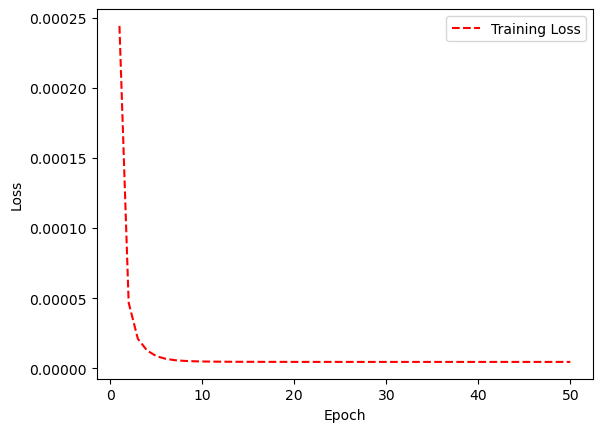

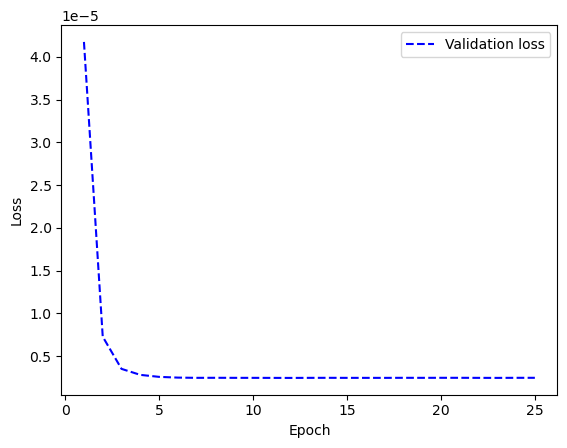

In [106]:
training_losses = []
validation_losses = []
min_validation_loss = np.Inf
validate_every = 2

# Set to train mode
model.train()

for epoch in tqdm(range(EPOCHS)):
    # Initialize hidden and cell states with dimension:
    # (num_layers * num_directions, batch, hidden_size)
    states = model.init_hidden_states(BATCH_SIZE)
    running_training_loss = 0.0

    # Begin training
    for idx, (x_batch, y_batch) in enumerate(training_dl):
        # Convert to Tensors
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.float().to(device)

        # Truncated Backpropagation
        states = [state.detach() for state in states]

        optimizer.zero_grad()

        # Make prediction
        output, states = model(x_batch, states)

        # Calculate loss
        loss = criterion(output[:, -1, :], y_batch.squeeze())
        loss.backward()
        running_training_loss += loss.item()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    # Average loss across timesteps
    training_losses.append(running_training_loss / len(training_dl))

    if epoch % validate_every == 0:
        # Set to eval mode
        model.eval()

        validation_states = model.init_hidden_states(BATCH_SIZE)
        running_validation_loss = 0.0

        for idx, (x_batch, y_batch) in enumerate(validation_dl):
            # Convert to Tensors
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)

            validation_states = [state.detach() for state in validation_states]
            output, validation_states = model(x_batch, validation_states)
            validation_loss = criterion(output[:, -1, :], y_batch.squeeze())
            running_validation_loss += validation_loss.item()

        validation_losses.append(running_validation_loss / len(validation_dl))
        # Reset to training mode
        model.train()

        is_best = running_validation_loss / len(validation_dl) < min_validation_loss

        if is_best:
            min_validation_loss = running_validation_loss / len(validation_dl)
            save_checkpoint(epoch + 1, min_validation_loss, model.state_dict(), optimizer.state_dict())

# Visualize loss
epoch_count = range(1, len(training_losses) + 1)
plt.plot(epoch_count, training_losses, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

val_epoch_count = range(1, len(validation_losses) + 1)
plt.plot(val_epoch_count, validation_losses, 'b--')
plt.legend(['Validation loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [139]:
test_panel['Asset_ID'] = Asset_ID
test_panel = test_panel.fillna(0)
test_ds = GruDataset(test_panel, SEQ_LENGTH)
test_dl = DataLoader(test_ds, **params)

100%|██████████████████████████████████████████████████████████████████████| 208611/208611 [00:00<00:00, 1705969.19it/s]


In [140]:
prediction = []
l = []
with torch.no_grad():
    for idx, (x_batch, y_batch) in enumerate(test_dl):
        # Convert to Tensors
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.float().to(device)

        validation_states = [state.detach() for state in validation_states]
        output, validation_states = model(x_batch, validation_states)
        prediction.extend(output[:, -1, :].cpu().numpy().tolist())

In [158]:
prediction

[[0.000499856541864574],
 [0.0004138661315664649],
 [0.00048807100392878056],
 [0.0004699386190623045],
 [0.0005631290841847658],
 [0.0004712024237960577],
 [0.0005877329967916012],
 [0.00047739187721163034],
 [0.00047279754653573036],
 [0.0005038050003349781],
 [0.0005860594101250172],
 [0.0004876118618994951],
 [0.00044265633914619684],
 [0.0003363386495038867],
 [0.0004301565932109952],
 [0.0006676553748548031],
 [0.0006187267135828733],
 [0.0005163511959835887],
 [0.0005729552358388901],
 [0.0006127231754362583],
 [0.0005162293091416359],
 [0.0005015432834625244],
 [0.0006650872528553009],
 [0.0006539046298712492],
 [0.0005714853759855032],
 [0.0006175560411065817],
 [0.0004703747108578682],
 [0.0003690379671752453],
 [0.0002616222482174635],
 [0.00037867866922169924],
 [0.0004495191387832165],
 [0.0005247239023447037],
 [0.0004342955071479082],
 [0.0004973638569936156],
 [0.0005578433629125357],
 [0.0005245594074949622],
 [0.0005897103110328317],
 [0.00051549868658185],
 [0.000380

In [176]:
np.linspace(1, 10, 10)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

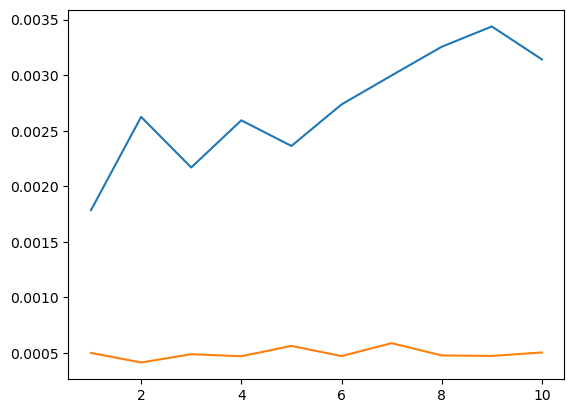

In [177]:
np.cov(test_panel['Target'].iloc[:len(prediction)].to_list(), pd.Series(prediction).apply(lambda x:x[0]))
plt.plot(np.linspace(1, 10, 10), test_panel['Target'].iloc[:len(prediction)].to_list()[0:10])
plt.plot(np.linspace(1, 10, 10), pd.Series(prediction).apply(lambda x:x[0])[0:10])

In [107]:
path = "./model_state.pt"
model, optimizer, start_epoch, valid_loss_min = load_checkpoint(path, model, optimizer)
print("model = ", model)
print("optimizer = ", optimizer)
print("start_epoch = ", start_epoch)
print("valid_loss_min = ", valid_loss_min)
print("valid_loss_min = {:.6f}".format(valid_loss_min))

model =  LSTM(
  (lstm): LSTM(56, 100, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
optimizer =  AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)
start_epoch =  24
valid_loss_min =  2.4400818535438895e-06
valid_loss_min = 0.000002
